# BA 476 Final Project - Diabetes Prediction


In this project we'll create a model to predict whether or not a person has diabetes. We'll be working with a dataset containing 100,000 instances and 16 features (excluding the outcome variable). We'll begin by exploring the data and the relationships between predictors and the outcome. Then we'll preprocess the data and try out all of the models we learned about this semester. From there, we'll select the three best performing models and try out some feature engineering and feature selection. We'll then use nested cross-validation to select the best overall model. Finally, we'll run cross-validation once again to tune our final model's hyperparameters and evaluate overall performance.

We aim to create a model with good overall accuracy, but since the cost of false negatives could be high in diabetes diagnosis, our priority will be to maximize recall.

Kaggle Dataset: https://www.kaggle.com/datasets/ziya07/diabetes-clinical-dataset100k-rows/data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Exploration

In [ ]:
data_path = '/content/drive/MyDrive/BA476Project/diabetes_dataset_with_notes.csv'

# Load the data
df = pd.read_csv(data_path)
df.head()

,year,gender,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes,clinical_notes
0,2020,Female,32.0,Alabama,0,0,0,0,1,0,0,never,27.32,5.0,100,0,"Overweight, advised dietary and exercise modif..."
1,2015,Female,29.0,Alabama,0,1,0,0,0,0,0,never,19.95,5.0,90,0,Healthy BMI range.
2,2015,Male,18.0,Alabama,0,0,0,0,1,0,0,never,23.76,4.8,160,0,"Young patient, generally lower risk but needs ..."
3,2015,Male,41.0,Alabama,0,0,1,0,0,0,0,never,27.32,4.0,159,0,"Overweight, advised dietary and exercise modif..."
4,2016,Female,52.0,Alabama,1,0,0,0,0,0,0,never,23.75,6.5,90,0,"Healthy BMI range. High HbA1c level, indicativ..."


First we'll check for missing values in our dataset.

In [ ]:
# check for missing values
df.isna().sum()

,0
year,0
gender,0
age,0
location,0
race:AfricanAmerican,0
race:Asian,0
race:Caucasian,0
race:Hispanic,0
race:Other,0
hypertension,0


Next, we'll quickly encode categorical variables and take a look at the correlation matrix.

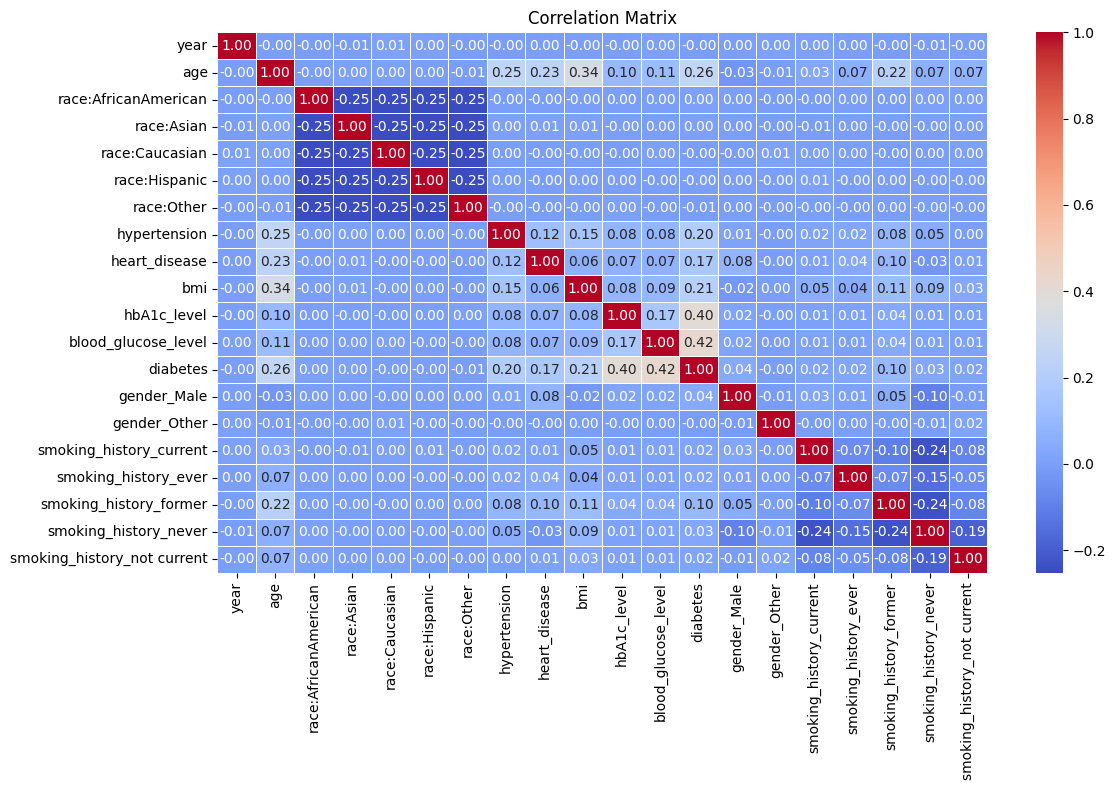

In [ ]:
df_encoded = df.copy()

# encode categorical variables
categorical_cols = ['gender', 'smoking_history']
df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, drop_first=True)

df_encoded['year'] = pd.to_numeric(df_encoded['year'], errors='coerce')
df_encoded['age'] = pd.to_numeric(df_encoded['age'], errors='coerce')

df_corr = df_encoded.drop(columns=['clinical_notes', 'location'], errors='ignore')

# plot the correlation matrix
corr_matrix = df_corr.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

Here we'll take a look at some basic summary stats.

In [ ]:
df.describe(include='all')

,year,gender,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes,clinical_notes
count,100000.000000,100000,100000.000000,100000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.00000,100000.000000,100000,100000.000000,100000.000000,100000.000000,100000.000000,100000
unique,NaN,3,NaN,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,761
top,NaN,Female,NaN,Kentucky,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Info,NaN,NaN,NaN,NaN,"Overweight, advised dietary and exercise modif..."
freq,NaN,58552,NaN,2038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35816,NaN,NaN,NaN,NaN,4650
mean,2018.360820,NaN,41.885856,NaN,0.202230,0.200150,0.198760,0.19888,0.199980,0.07485,0.039420,NaN,27.320767,5.527507,138.058060,0.085000,NaN
std,1.345239,NaN,22.516840,NaN,0.401665,0.400114,0.399069,0.39916,0.399987,0.26315,0.194593,NaN,6.636783,1.070672,40.708136,0.278883,NaN
min,2015.000000,NaN,0.080000,NaN,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,NaN,10.010000,3.500000,80.000000,0.000000,NaN
25%,2019.000000,NaN,24.000000,NaN,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,NaN,23.630000,4.800000,100.000000,0.000000,NaN
50%,2019.000000,NaN,43.000000,NaN,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,NaN,27.320000,5.800000,140.000000,0.000000,NaN
75%,2019.000000,NaN,60.000000,NaN,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,NaN,29.580000,6.200000,159.000000,0.000000,NaN


In [ ]:
df['diabetes'].value_counts(normalize=True)

,proportion
diabetes,
0,0.915
1,0.085


### Resampled Dataset

Our dataset has major class imbalance, with the vast majority of instances belonging to the "no diabetes" class. Since this could cause problems in model building, we'll address it be resampling from the original dataset, downsampling the "no diabetes" instances. We'll aim for a 2:1 ratio of non-diabetes to diabetes cases since its still important to reflect the fact that the vast majority of instances will be non-diabetes.

In [ ]:
# downsample the 0 class, with a target 2:1 split
X = df.drop(columns=['diabetes'])
y = df['diabetes']

rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

X_resampled, y_resampled = rus.fit_resample(X, y)

print(y.value_counts())
print(y_resampled.value_counts())

df_resampled = pd.concat([X_resampled, y_resampled], axis=1)

diabetes
0    91500
1     8500
Name: count, dtype: int64
diabetes
0    17000
1     8500
Name: count, dtype: int64


Now we'll take a look at the correlation matrix and summary stats from our resampled dataset.

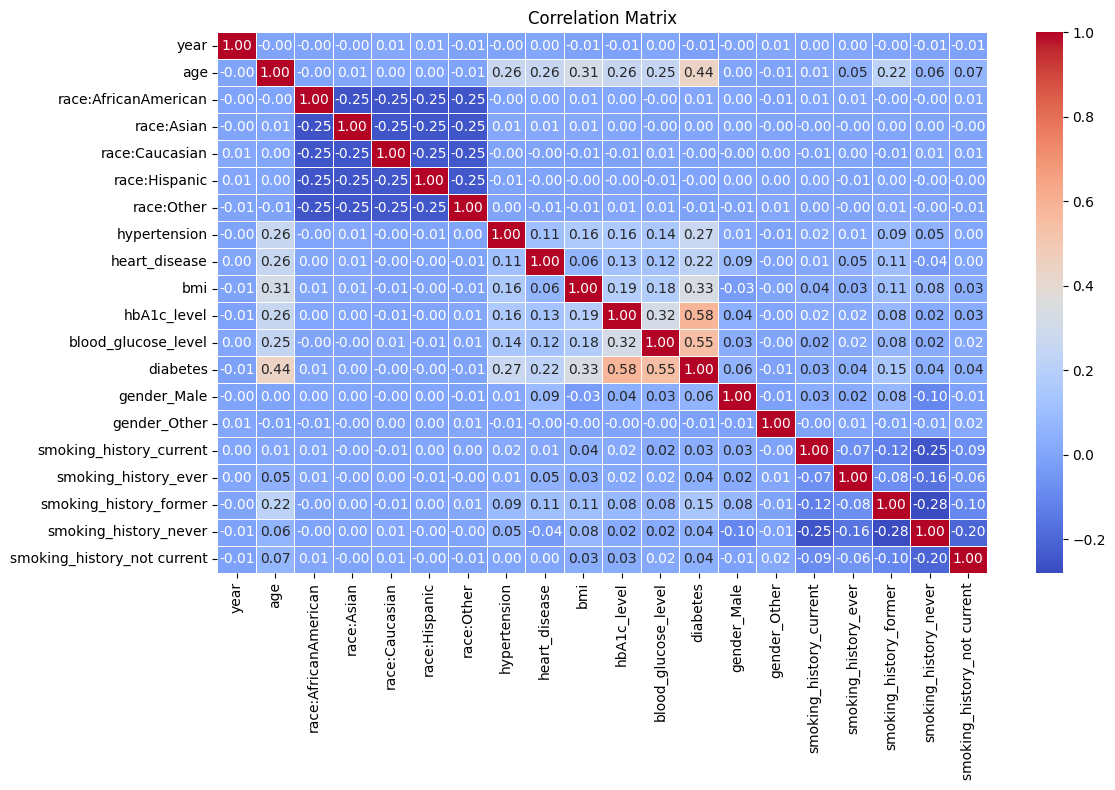

In [ ]:
df_encoded = df_resampled.copy()

# encode categorical variables
categorical_cols = ['gender', 'smoking_history']
df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, drop_first=True)

df_encoded['year'] = pd.to_numeric(df_encoded['year'], errors='coerce')
df_encoded['age'] = pd.to_numeric(df_encoded['age'], errors='coerce')

df_corr = df_encoded.drop(columns=['clinical_notes', 'location'], errors='ignore')

# plot the correlation matrix
corr_matrix = df_corr.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

In [ ]:
df_encoded.describe(include='all')

,year,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,...,blood_glucose_level,clinical_notes,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
count,25500.000000,25500.000000,25500,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,...,25500.000000,25500,25500.000000,25500,25500,25500,25500,25500,25500,25500
unique,NaN,NaN,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,658,NaN,2,2,2,2,2,2,2
top,NaN,NaN,Kentucky,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"Overweight, advised dietary and exercise modif...",NaN,False,False,False,False,False,False,False
freq,NaN,NaN,560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,920,NaN,14449,25495,23017,24370,22465,16174,23784
mean,2018.372706,47.231868,NaN,0.203255,0.202941,0.197412,0.199333,0.197059,0.122157,0.069373,...,153.421216,NaN,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.336216,22.242335,NaN,0.402429,0.402197,0.398053,0.399507,0.397785,0.327473,0.254092,...,52.661336,NaN,0.471414,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2015.000000,0.080000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,80.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2019.000000,30.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,126.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2019.000000,50.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,145.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2019.000000,65.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,160.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_resampled.head()

,year,gender,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,clinical_notes,diabetes
21695,2019,Female,51.0,Georgia,0,0,1,0,0,0,0,No Info,27.32,5.8,100,"Overweight, advised dietary and exercise modif...",0
62724,2019,Female,50.0,New Jersey,0,1,0,0,0,0,0,former,22.24,6.2,90,"Healthy BMI range. History of smoking, potenti...",0
38668,2019,Female,63.0,Louisiana,1,0,0,0,0,0,0,former,31.08,5.7,100,Elderly patient with increased risk of chronic...,0
72816,2019,Female,18.0,Ohio,0,0,0,1,0,0,0,No Info,22.03,6.5,80,"Young patient, generally lower risk but needs ...",0
14780,2019,Female,50.0,Delaware,0,0,0,1,0,0,0,never,24.27,4.0,80,Healthy BMI range. Consideration for metabolic...,0


In [ ]:
df_resampled.shape

(25500, 17)

Now we'll get a better look at the distributions of predictors and the relationships between them. We'll start with the age distribution, where we see many are on the older side.

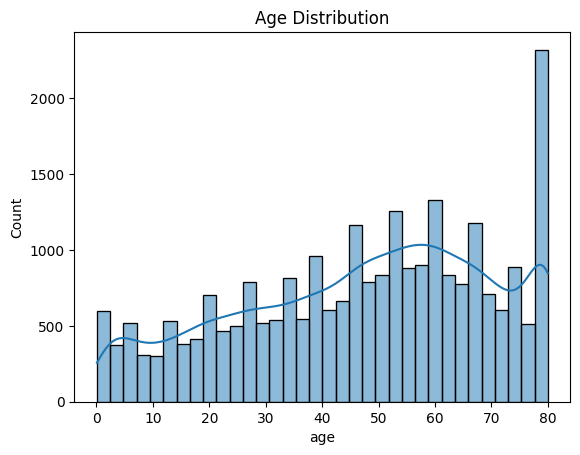

In [ ]:
# Basic histograms to check predictor distribution

sns.histplot(df_resampled['age'], kde=True)
plt.title("Age Distribution")
plt.show()

Here we see the BMI and blood glucose level distributions.

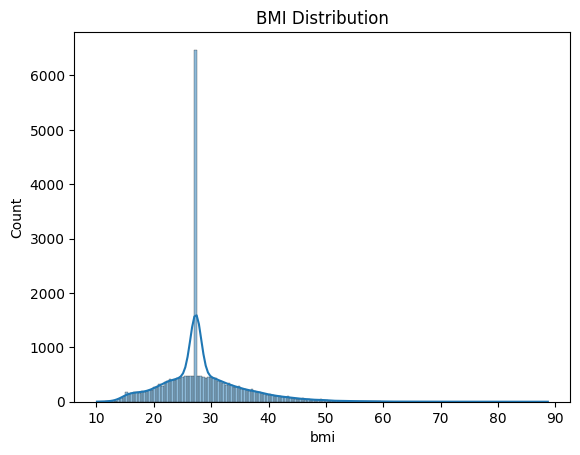

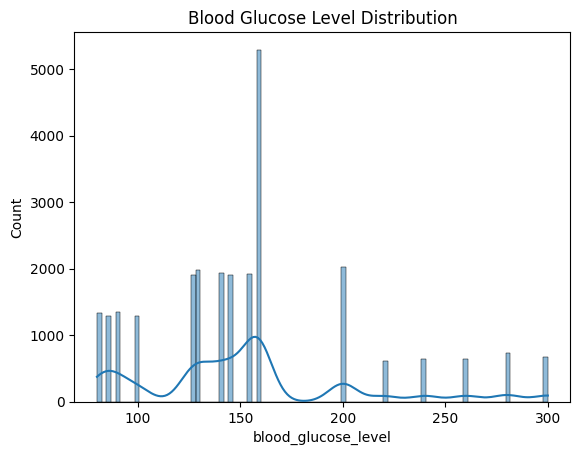

In [ ]:
# A few more histograms to better understand
# the dataset in use

sns.histplot(df_resampled['bmi'], kde=True)
plt.title("BMI Distribution")
plt.show()

sns.histplot(df_resampled['blood_glucose_level'], kde=True)
plt.title("Blood Glucose Level Distribution")
plt.show()

We have a lot more non-hypertension instances.

In [ ]:
df_resampled['hypertension'].value_counts(normalize=True)

,proportion
hypertension,
0,0.877843
1,0.122157


Now we'll look at some relationships between the predictors and the outcome with some boxplots. We can clearly see that those with diabetes tend to be on the older side, tend to have a higher BMI, and have a higher blood glucose level (this one is of course to be expected). Given these relationships, it seems these variables should end up being strong predictors.

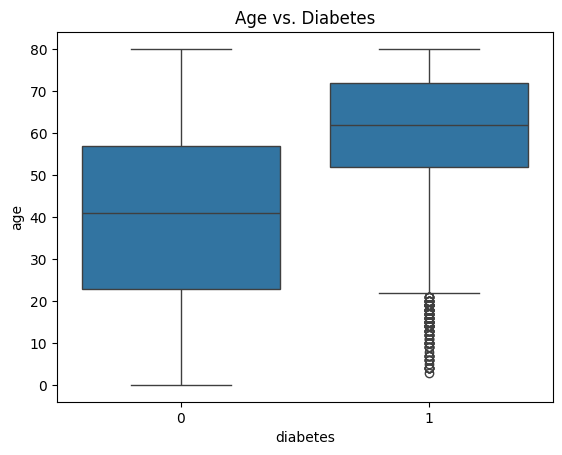

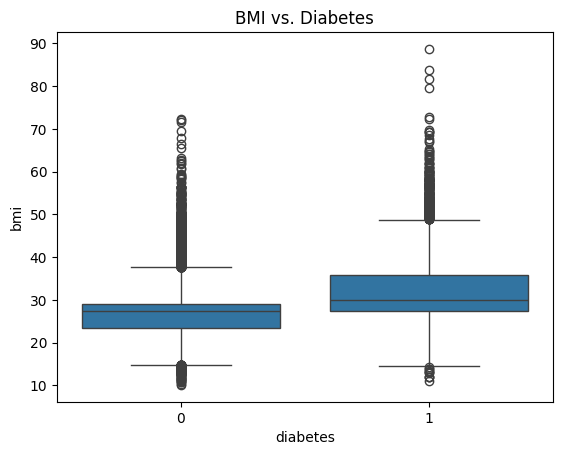

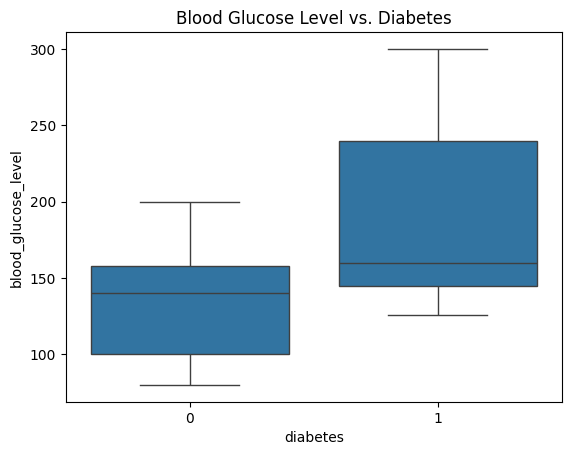

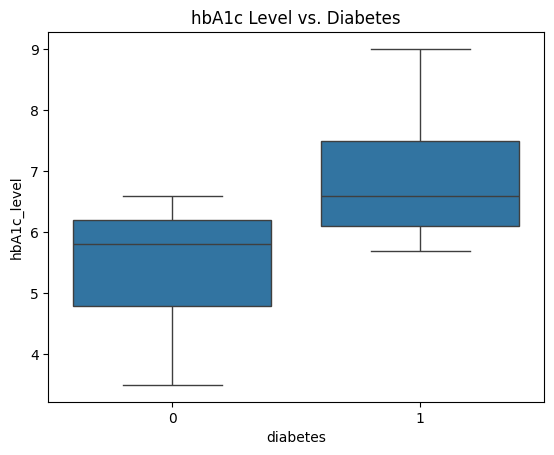

In [ ]:
# Boxplots to check relationship of these predictors
# with 'diabetes'

sns.boxplot(x='diabetes', y='age', data=df_resampled)
plt.title("Age vs. Diabetes")
plt.show()

sns.boxplot(x='diabetes', y='bmi', data=df_resampled)
plt.title("BMI vs. Diabetes")
plt.show()

sns.boxplot(x='diabetes', y='blood_glucose_level', data=df_resampled)
plt.title("Blood Glucose Level vs. Diabetes")
plt.show()

sns.boxplot(x='diabetes', y='hbA1c_level', data=df_resampled)
plt.title("hbA1c Level vs. Diabetes")
plt.show()

We have a good amount more females than males in our resampled dataset.

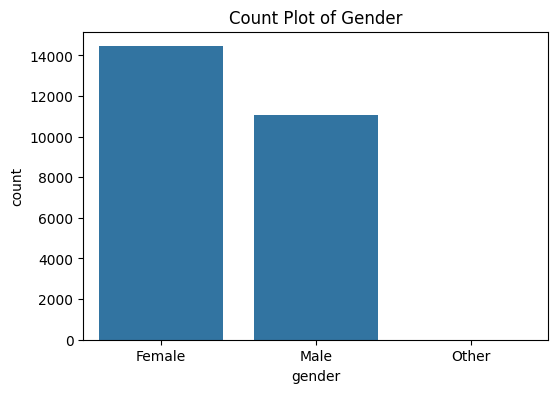

In [ ]:
# Looking at other categorical variables and
# how they are distibuted within the dataset
plt.figure(figsize=(6,4))
sns.countplot(data=df_resampled, x='gender')
plt.title('Count Plot of Gender')
plt.show()

Here we can see that the distribution of diabetes/no-diabetes cases seems to be pretty balanced across all races, so race may not end up being a very strong predictor.

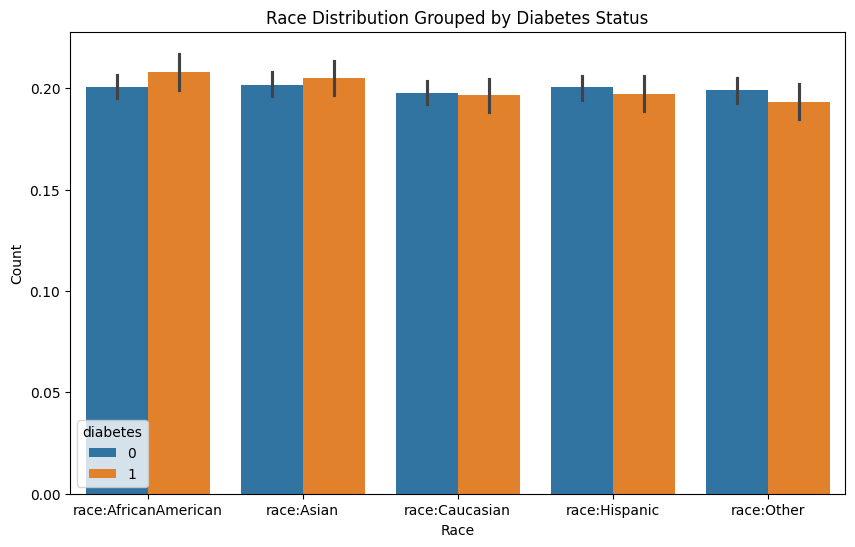

In [ ]:
# Distribution of diabetic patients within different races
race_cols = ['race:AfricanAmerican', 'race:Asian', 'race:Caucasian', 'race:Hispanic', 'race:Other']
race_df = df_resampled[race_cols + ['diabetes']].copy()
race_df = race_df.melt(id_vars='diabetes', var_name='Race', value_name='Count')

plt.figure(figsize=(10,6))
sns.barplot(data=race_df, x='Race', y='Count', hue='diabetes')
plt.title('Race Distribution Grouped by Diabetes Status')
plt.show()

Here we see some predictor averages for diabetic and non-diabetic instances. Again we see higher BMI, blood glucose levels, hbA1c levels, and more hypertension among those with diabetes.

In [ ]:
# Diabetic vs. Non-Diabetic Individual's average predictor stats
# 1 is diabetic

df_resampled.groupby('diabetes')[['age', 'bmi', 'hbA1c_level', 'blood_glucose_level', 'hypertension']].mean()

,age,bmi,hbA1c_level,blood_glucose_level,hypertension
diabetes,,,,,
0,40.374508,26.943177,5.401847,133.084471,0.060412
1,60.946588,31.988382,6.934953,194.094706,0.245647


Below is the distribution of smoking history in the dataset.

In [ ]:
df_resampled['smoking_history'].value_counts(normalize=True)

,proportion
smoking_history,
never,0.365725
No Info,0.306275
former,0.119020
current,0.097373
not current,0.067294
ever,0.044314


We'll create some more concise and hopefully more useful groupings of smoking statuses here.

In [ ]:
# Grouping smoking histories to simplufy and better
# understand their impact on the outcome of the individual

def group_smoking_status(value):
    if value == "never":
        return "never"
    elif value == "current":
        return "current"
    elif value in ["former", "ever", "not current"]:
        return "past"
    elif value == "No Info":
        return "unknown"
    else:
        return "unknown"

df_resampled['smoking_status_grouped'] = df_resampled['smoking_history'].apply(group_smoking_status)
df_resampled['smoking_status_grouped'].value_counts(normalize=True)

,proportion
smoking_status_grouped,
never,0.365725
unknown,0.306275
past,0.230627
current,0.097373


Here we have proportions of instances with each smoking status that have diabetes. It seems that those with past smoking history have higher rates, and we suspect those that currently smoke may not have done so long enough to experience the effect, which would explain the slightly lower levels of diabetes for them.

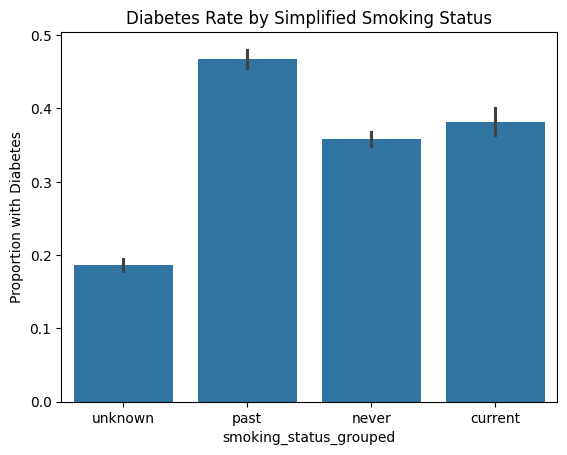

In [ ]:
sns.barplot(x='smoking_status_grouped', y='diabetes', data=df_resampled)
plt.title('Diabetes Rate by Simplified Smoking Status')
plt.ylabel('Proportion with Diabetes')
plt.show()

Here we un-encode race for temporary ease of use.

In [ ]:
# Grouping race categories into a single variable
# This is to avoid multi-collinearity

race_cols = [col for col in df_resampled.columns if col.startswith('race:')]

def get_race(row):
    for col in race_cols:
        if row[col] == 1:
            return col.split(':')[1]  # Extracts the label after 'race:'
    return 'Unknown'

df_resampled['race_group'] = df_resampled.apply(get_race, axis=1)
df_resampled['race_group'].value_counts(normalize=True)

,proportion
race_group,
AfricanAmerican,0.203255
Asian,0.202941
Hispanic,0.199333
Caucasian,0.197412
Other,0.197059


In [ ]:
# Removing the original columns and keeping only the grouped one
df_resampled.drop(columns=race_cols, inplace=True)

Now we'll try to get a better sense of the relationship between smoking status and the other predictors.

In [ ]:
# Does smoking affect the main predictors?

df_resampled.groupby('smoking_status_grouped')[['age', 'bmi', 'hbA1c_level', 'blood_glucose_level']].mean()

,age,bmi,hbA1c_level,blood_glucose_level
smoking_status_grouped,,,,
current,47.703343,29.484418,5.988562,157.024567
never,48.915917,29.411759,5.953303,154.920652
past,56.770733,30.211952,6.117106,160.837273
unknown,37.888184,26.217017,5.686773,144.900768


Past smokers are obviously on the older side and seem to maybe have higher blood glucose levels.

Text(0.5, 1.0, 'Age by Smoking Status')

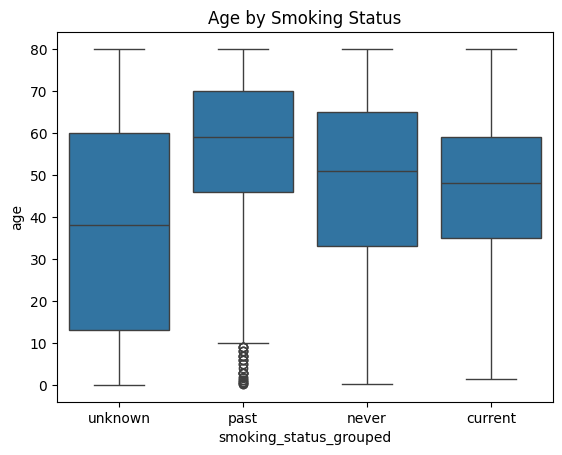

In [ ]:
# Some visualizations to better understand the effects of smoking history

sns.boxplot(x='smoking_status_grouped', y='age', data=df_resampled)
plt.title("Age by Smoking Status")

Text(0.5, 1.0, 'Blood Glucose by Smoking Status')

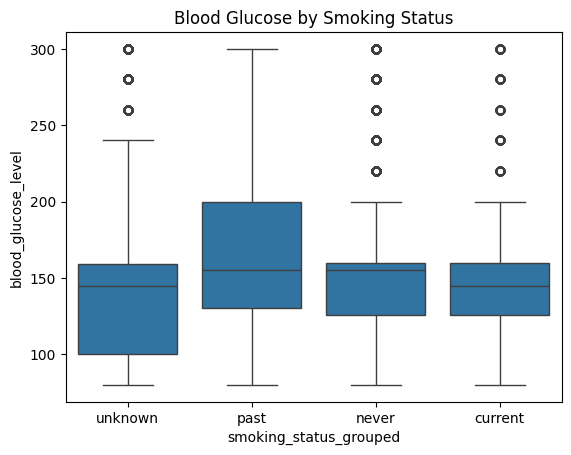

In [ ]:
sns.boxplot(x='smoking_status_grouped', y='blood_glucose_level', data=df_resampled)
plt.title("Blood Glucose by Smoking Status")

Here we see the correlation between age and other predictors.

In [ ]:
df_resampled.corr(numeric_only=True)['age'].sort_values(ascending=False)

,age
age,1.000000
diabetes,0.436014
bmi,0.311663
hypertension,0.260658
heart_disease,0.257143
hbA1c_level,0.256356
blood_glucose_level,0.248797
year,-0.002495


## Preprocessing

Now we'll preprocess our data before building models. We'll one-hot encode all of our categorical features, standarize our numerical features, drop unnecassary columns, and perform a VIF check.

In [ ]:
df_resampled.columns

Index(['year', 'gender', 'age', 'location', 'hypertension', 'heart_disease',
       'smoking_history', 'bmi', 'hbA1c_level', 'blood_glucose_level',
       'clinical_notes', 'diabetes', 'smoking_status_grouped', 'race_group'],
      dtype='object')

In [ ]:
# Save a copy before processing so we can use these original values later
df_original = df_resampled.copy()

In [ ]:
# One-hot encoding for race
race_dummies = pd.get_dummies(df_resampled["race_group"], prefix="race", drop_first=True)
df_resampled = pd.concat([df_resampled.drop("race_group", axis=1), race_dummies], axis=1)

In [ ]:
# One-hot encoding for gender
gender_dummies = pd.get_dummies(df_resampled["gender"], prefix="gender", drop_first=True)
df_resampled = pd.concat([df_resampled.drop("gender", axis=1), gender_dummies], axis=1)

In [ ]:
# One-hot encoding for location
state_dummies = pd.get_dummies(df_resampled["location"], prefix="state", drop_first=True)
df_resampled = pd.concat([df_resampled.drop("location", axis=1), state_dummies], axis=1)

In [ ]:
# One-hot encoding for smoking status
smoking_dummies = pd.get_dummies(df_resampled["smoking_status_grouped"], prefix="smoking", drop_first=True)
df_resampled = pd.concat([df_resampled.drop("smoking_status_grouped", axis=1), smoking_dummies], axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_col = ['age','bmi','hbA1c_level','blood_glucose_level']
df_resampled[num_col] = scaler.fit_transform(df_resampled[num_col])

Upon inspecting clinical_notes, it seems to only include information that is descriptive of what is already contained in other columns, so we'll just drop it outright. We'll also drop the original un-encoded smoking_history column.

In [ ]:
df_resampled.drop(columns=['clinical_notes', 'smoking_history'], inplace=True)

Next we'll calculate VIF scores to check for multicollinearity:

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

def compute_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

X = df_resampled.drop('diabetes', axis=1).copy()
vif_df = compute_vif(X.astype(int))
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
print(vif_df)

                       feature        VIF
0                         year  65.289813
1                          age   1.244914
2                 hypertension   1.234401
3                heart_disease   1.160885
4                          bmi   1.124783
5                  hbA1c_level   1.134152
6          blood_glucose_level   1.150868
7                   race_Asian   2.002333
8               race_Caucasian   1.975897
9                race_Hispanic   1.985863
10                  race_Other   1.974714
11                 gender_Male   1.810305
12                gender_Other   1.003314
13                state_Alaska   2.040814
14               state_Arizona   1.872208
15              state_Arkansas   2.076684
16            state_California   2.003240
17              state_Colorado   1.995281
18           state_Connecticut   2.062395
19              state_Delaware   2.054176
20  state_District of Columbia   2.033014
21               state_Florida   1.969274
22               state_Georgia   2

All features have VIF scores below 5 except for year which is high at ~65, so we'll drop the year column.

In [ ]:
df_resampled.drop(columns=['year'], inplace=True)

In [ ]:
df_resampled.head()

,age,hypertension,heart_disease,bmi,hbA1c_level,blood_glucose_level,diabetes,race_Asian,race_Caucasian,race_Hispanic,...,state_Vermont,state_Virgin Islands,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,smoking_never,smoking_past,smoking_unknown
21695,0.169416,0,0,-0.181738,-0.090983,-1.014449,0,False,True,False,...,False,False,False,False,False,False,False,False,False,True
62724,0.124456,0,0,-0.889238,0.231417,-1.204346,0,True,False,False,...,False,False,False,False,False,False,False,False,True,False
38668,0.708938,0,0,0.341925,-0.171583,-1.014449,0,False,False,False,...,False,False,False,False,False,False,False,False,True,False
72816,-1.314270,0,0,-0.918486,0.473217,-1.394242,0,False,False,True,...,False,False,False,False,False,False,False,False,False,True
14780,0.124456,0,0,-0.606517,-1.541783,-1.394242,0,False,False,True,...,False,False,False,False,False,False,False,True,False,False


## Model Building

Now we'll start building models to get a sense of which ones will perform best and will be worth looking into further with feature engineering and nested CV. We'll look at 10 models we learned about this semester including KNN, logistic regression, logistic regression with Ridge and Lasso, decision trees, bagging, random forests, gradient boosting, AdaBoost, and XGBoost.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

X = df_resampled.drop('diabetes', axis=1)
y = df_resampled['diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We'll use this function to quickly evaluate each model with a classification report and a comfusion matrix.

In [ ]:
def evaluate_model(model, X_test, y_test, class_names=['No Diabetes', 'Diabetes'], model_name=""):
    # Predict
    y_pred = model.predict(X_test)

    # Print classification report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.tight_layout()
    plt.show()

### KNN

KNN performs decently well overall, but the recall is lacking.


KNN Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      3409
           1       0.84      0.78      0.81      1691

    accuracy                           0.88      5100
   macro avg       0.87      0.85      0.86      5100
weighted avg       0.88      0.88      0.88      5100



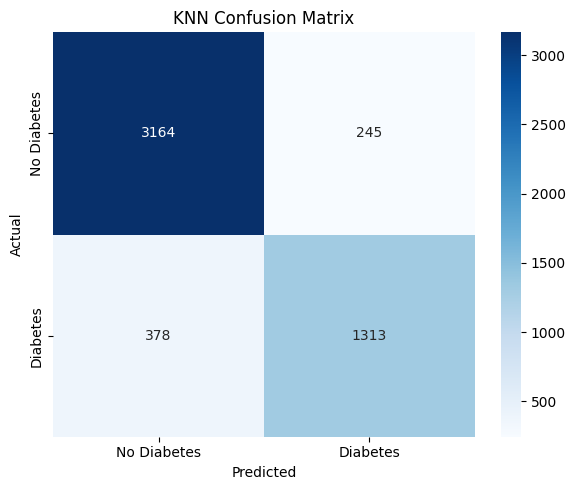

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Train KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

evaluate_model(knn, X_test, y_test, model_name='KNN')

### Logistic Regression

Logistic regression seems to be a good baseline estimator.


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      3409
           1       0.85      0.81      0.83      1691

    accuracy                           0.89      5100
   macro avg       0.88      0.87      0.88      5100
weighted avg       0.89      0.89      0.89      5100



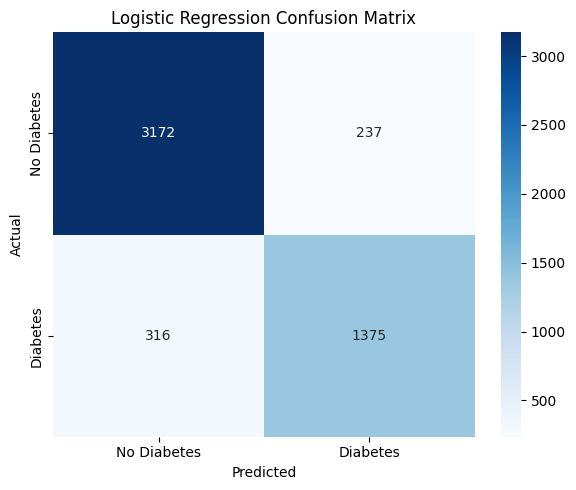

In [ ]:
from sklearn.linear_model import LogisticRegression

# Train logistic regression model
logreg = LogisticRegression(max_iter=1000, solver='liblinear')
logreg.fit(X_train, y_train)

evaluate_model(logreg, X_test, y_test, model_name='Logistic Regression')

#### Ridge

Adding Ridge doesn't seem to have had much of and effect on logistic regression.


Logistic Regression with Ridge Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      3409
           1       0.86      0.81      0.83      1691

    accuracy                           0.89      5100
   macro avg       0.88      0.87      0.88      5100
weighted avg       0.89      0.89      0.89      5100



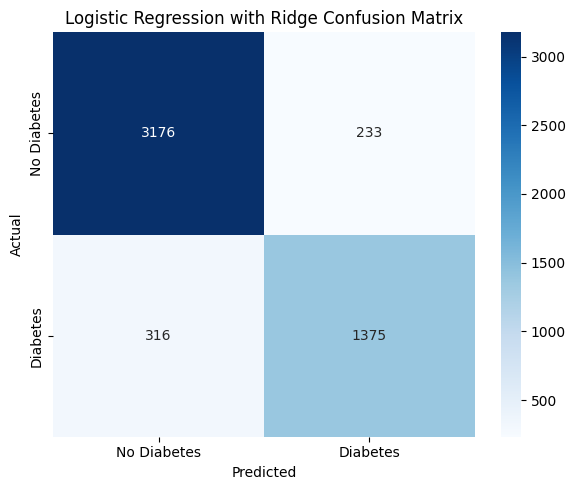

In [ ]:
# Train logistic regression model with Ridge regularization
logreg_ridge = LogisticRegression(penalty='l2', C=0.1, solver='liblinear', max_iter=1000)
logreg_ridge.fit(X_train, y_train)

# Evaluate the model
evaluate_model(logreg_ridge, X_test, y_test, model_name='Logistic Regression with Ridge')

#### Lasso

Lasso is still fairly similar to normal logistic regression, but it does seem to have had a tiny positive effect.


Logistic Regression with Lasso Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      3409
           1       0.86      0.81      0.84      1691

    accuracy                           0.89      5100
   macro avg       0.89      0.87      0.88      5100
weighted avg       0.89      0.89      0.89      5100



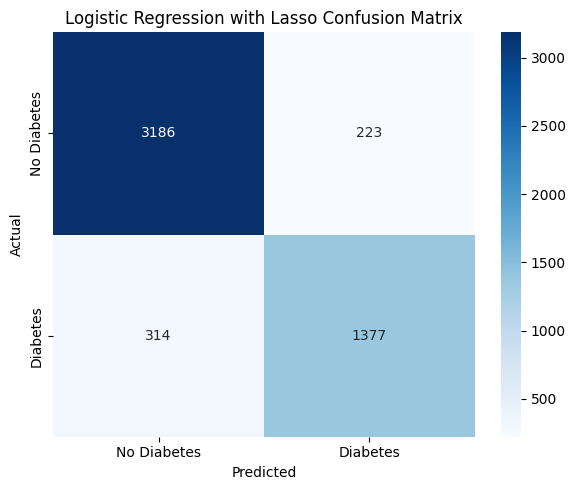

In [ ]:
# Train logistic regression with Lasso regularization
logreg_lasso = LogisticRegression(penalty='l1', C=0.1, solver='liblinear', max_iter=1000)
logreg_lasso.fit(X_train, y_train)

# Evaluate the model
evaluate_model(logreg_lasso, X_test, y_test, model_name='Logistic Regression with Lasso')

### Decision Tree

Decision trees definitely gave a bit of a performance boost.


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      3409
           1       0.82      0.83      0.83      1691

    accuracy                           0.88      5100
   macro avg       0.87      0.87      0.87      5100
weighted avg       0.88      0.88      0.88      5100



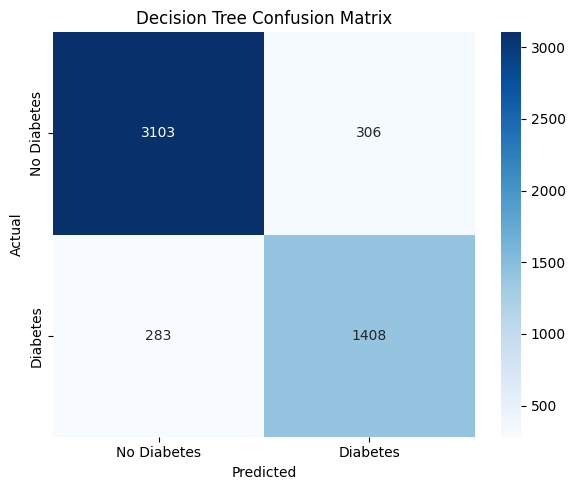

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Train decision tree model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Evaluate the model
evaluate_model(dt, X_test, y_test, model_name='Decision Tree')

### Bagging

Bagging does even better.


Bagging Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      3409
           1       0.89      0.84      0.86      1691

    accuracy                           0.91      5100
   macro avg       0.91      0.89      0.90      5100
weighted avg       0.91      0.91      0.91      5100



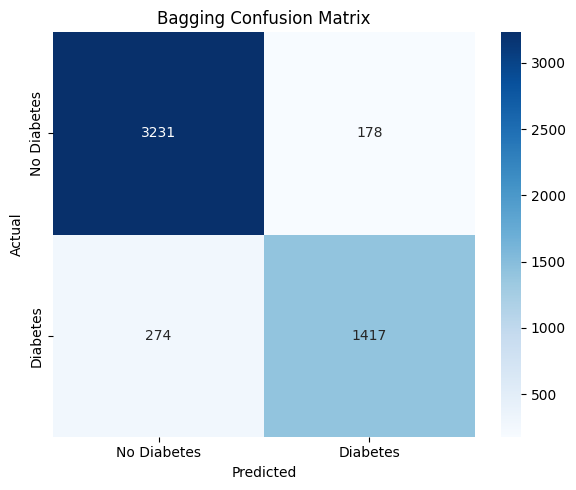

In [ ]:
from sklearn.ensemble import BaggingClassifier

# Train the bagging model
bagging = BaggingClassifier(n_estimators=100, random_state=42)
bagging.fit(X_train, y_train)

# Evaluate the model
evaluate_model(bagging, X_test, y_test, model_name='Bagging')

### Random Forest

Oddly, the random forest seems to have done slightly worse than bagging.


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      3409
           1       0.90      0.83      0.86      1691

    accuracy                           0.91      5100
   macro avg       0.91      0.89      0.90      5100
weighted avg       0.91      0.91      0.91      5100



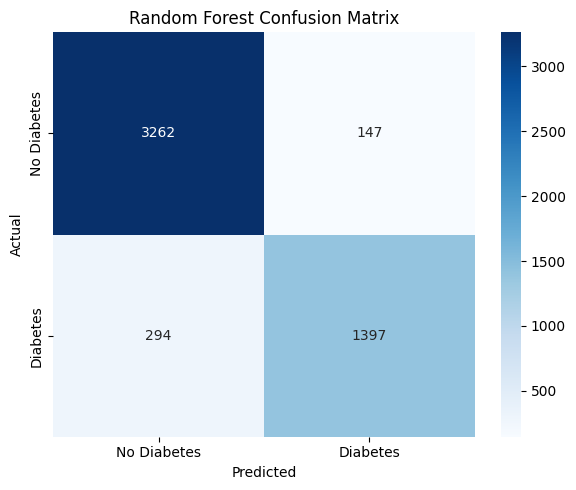

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train the random forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model
evaluate_model(rf, X_test, y_test, model_name='Random Forest')

### Boosting

#### Gradient Boosting

Gradient boosting gives the best performance so far.


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      3409
           1       0.91      0.84      0.87      1691

    accuracy                           0.92      5100
   macro avg       0.91      0.90      0.91      5100
weighted avg       0.92      0.92      0.92      5100



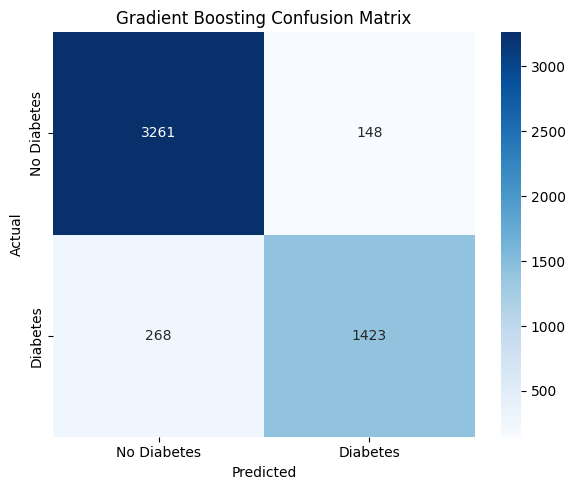

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Train the gradient boosting model
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)

# Evaluate the model
evaluate_model(gb, X_test, y_test, model_name='Gradient Boosting')

#### AdaBoost

AdaBoost seems to be a little worse than regular gradient boosting.


AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      3409
           1       0.90      0.83      0.86      1691

    accuracy                           0.91      5100
   macro avg       0.91      0.89      0.90      5100
weighted avg       0.91      0.91      0.91      5100



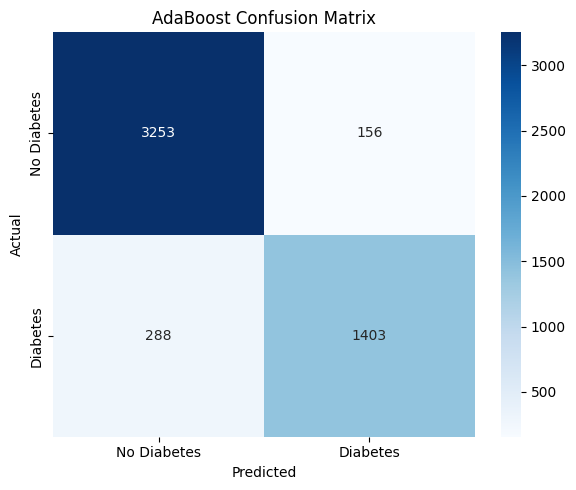

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Train the AdaBoost model
ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(X_train, y_train)

# Evaluate the model
evaluate_model(ada, X_test, y_test, model_name='AdaBoost')

#### XGBoost

XGBoost has a bunch more false positive than regular gradient boosting, but performed well overall.


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      3409
           1       0.88      0.84      0.86      1691

    accuracy                           0.91      5100
   macro avg       0.90      0.89      0.90      5100
weighted avg       0.91      0.91      0.91      5100



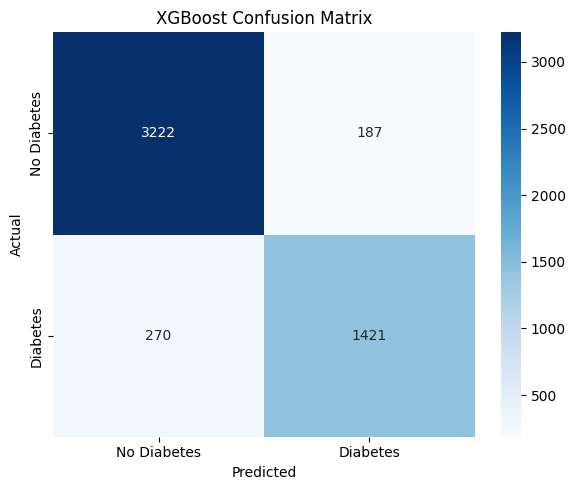

In [ ]:
import xgboost as xgb

# Train the XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate the model
evaluate_model(xgb_model, X_test, y_test, model_name='XGBoost')

Bagging, Gradient Boosting, and XGBoost seemed to have the best all-around performances, so we'll move forward with the three for feature engineering, feature selection, and nested CV.

## Model Complexity vs Performance Gain

Here we investigate the model complexity/performance gain tradeoff. Logisitic regression proved to be a pretty good baseline model with 81% recall, while the ensemble methods only provided 3-4% gains. We'll compare the Lasso logistic regression model with XGBoost, taking a look at coefficients and feature importances.

Lasso clearly performed feature selection, and there seem to only be a few features with strong importance.

In [ ]:
coefficients = pd.Series(logreg_lasso.coef_[0], index=X_train.columns)
coefficients_sorted = coefficients.sort_values(key=abs, ascending=False)
print(coefficients_sorted)

hbA1c_level            2.606174
blood_glucose_level    1.594555
age                    1.008082
heart_disease          0.803857
hypertension           0.739204
                         ...   
state_Washington       0.000000
state_Wisconsin        0.000000
state_West Virginia    0.000000
state_Wyoming          0.000000
smoking_past           0.000000
Length: 69, dtype: float64


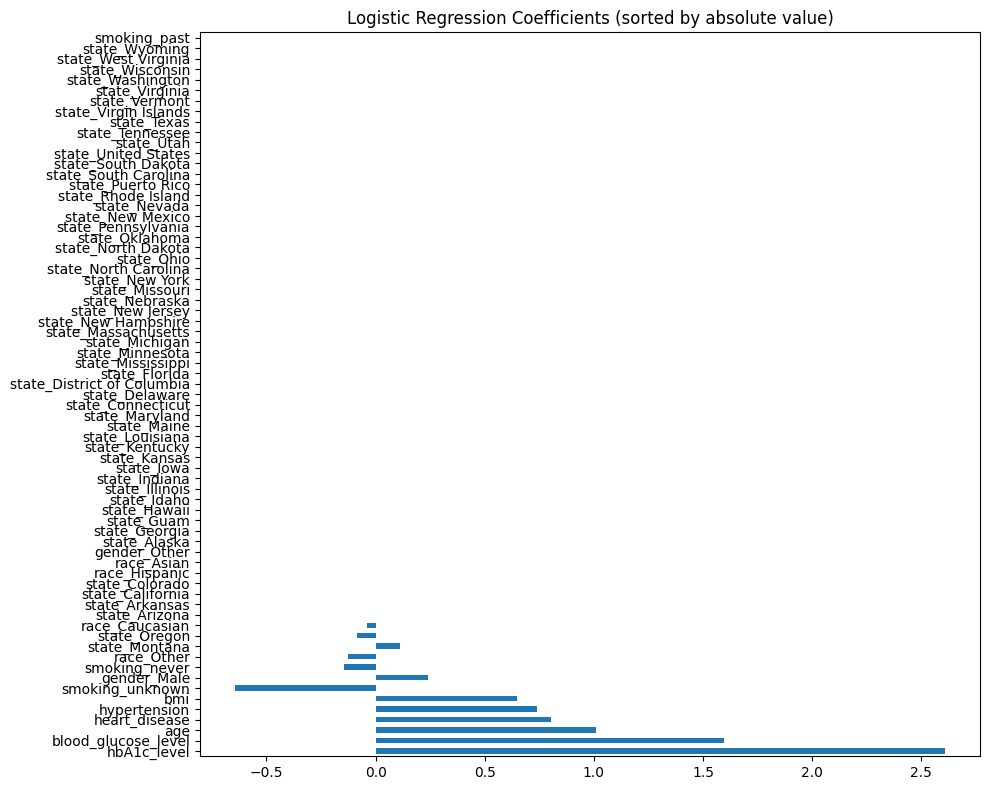

In [ ]:
coefficients_sorted.plot(kind='barh', figsize=(10, 8))
plt.title("Logistic Regression Coefficients (sorted by absolute value)")
plt.tight_layout()
plt.show()

Here we compare XGBoost feature importances and Lasso coefficients and plot the most important features in each model. We see that for the most part they have the same important features.

In [ ]:
importances = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'xgboost_importance': importances,
    'logistic_coeff': coefficients
}).sort_values('xgboost_importance', ascending=False)
pd.set_option('display.width', 200)
print(feature_importance_df)

                                 feature  xgboost_importance  logistic_coeff
hbA1c_level                  hbA1c_level            0.284906        2.606174
blood_glucose_level  blood_glucose_level            0.175780        1.594555
heart_disease              heart_disease            0.040619        0.803857
hypertension                hypertension            0.030698        0.739204
age                                  age            0.028036        1.008082
...                                  ...                 ...             ...
state_Arizona              state_Arizona            0.003879        0.000000
state_Wyoming              state_Wyoming            0.003822        0.000000
state_Delaware            state_Delaware            0.002974        0.000000
gender_Other                gender_Other            0.000000        0.000000
state_Wisconsin          state_Wisconsin            0.000000        0.000000

[69 rows x 3 columns]


<ipython-input-54-d119e2a4aded>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(top_features['feature'], rotation=45, ha='right')


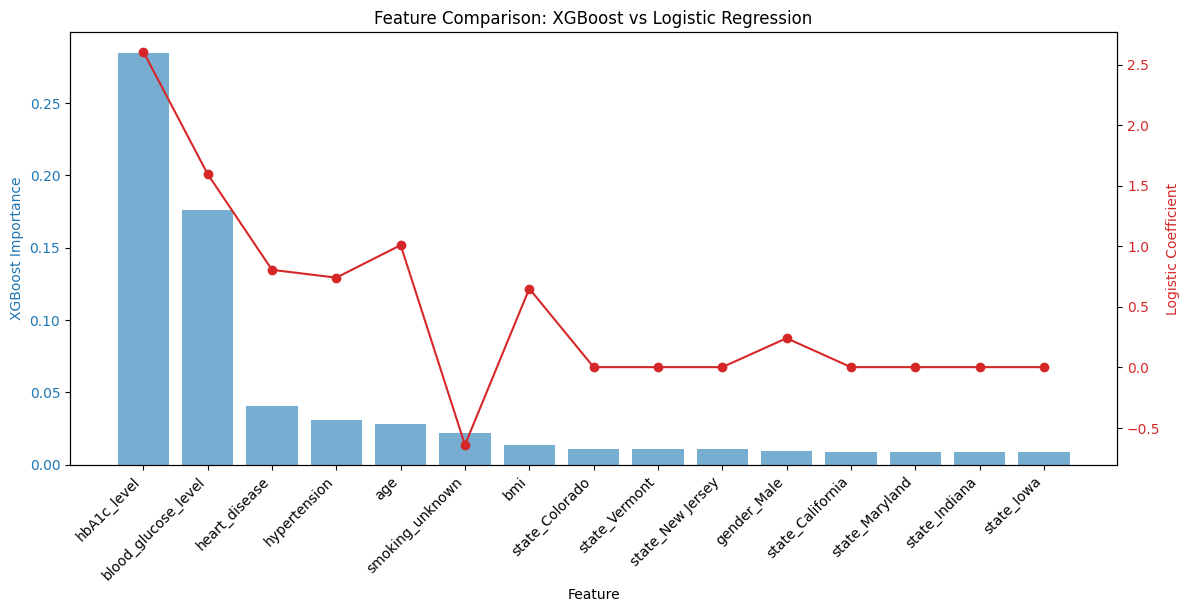

In [ ]:
top_features = feature_importance_df.head(15).copy()

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot XGBoost importance
color = 'tab:blue'
ax1.set_xlabel('Feature')
ax1.set_ylabel('XGBoost Importance', color=color)
ax1.bar(top_features['feature'], top_features['xgboost_importance'], color=color, alpha=0.6, label='XGBoost Importance')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(top_features['feature'], rotation=45, ha='right')

# Add Logistic Coefficient on secondary axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Logistic Coefficient', color=color)
ax2.plot(top_features['feature'], top_features['logistic_coeff'], color=color, marker='o', label='Logistic Coefficient')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Feature Comparison: XGBoost vs Logistic Regression')
plt.show()

Logistic regression performs well in this setting because the dominant predictive features (like hbA1c_level and blood_glucose_level) have strong, nearly linear relationships with the target. The addition of XGBoost yields only a modest performance gain, likely because it captures subtle nonlinearities and low-signal features, like individual state encodings, that Lasso regularizes to zero. This seems to indicate that for structured medical data with a few high-signal features like we have here, simpler models may suffice and offer better interpretability. However, for the purposes of this project in which we are concerned with prediction and not inference, we will continue on with ensemble methods to get the best predictive model we can.

## Feature Engineering

Potential ideas:


*   Bucket age
*   Convert BMI into categories (obese, overweight, etc.)
*   Bin risk categories for hbA1c and blood glucose level
*   Create interaction features (age x BMI, hypertension x heart disease, age x smoking history)






Based on some research, comorbidity and age/BMI interaction could be useful features here, so we'll try them out.

In [ ]:
df_resampled['comorbidity'] = df_resampled['hypertension'] + df_resampled['heart_disease']
df_resampled['age_bmi_interaction'] = df_original['age'] * df_original['bmi']
df_original['age_bmi_interaction'] = df_resampled['age_bmi_interaction']

In [ ]:
scaler = StandardScaler()
num_col = ['age','bmi','hbA1c_level','blood_glucose_level', 'age_bmi_interaction']
df_resampled[num_col] = scaler.fit_transform(df_original[num_col])
df_resampled.head()

,age,hypertension,heart_disease,bmi,hbA1c_level,blood_glucose_level,diabetes,race_Asian,race_Caucasian,race_Hispanic,...,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,smoking_never,smoking_past,smoking_unknown,comorbidity,age_bmi_interaction
21695,0.169416,0,0,-0.181738,-0.090983,-1.014449,0,False,True,False,...,False,False,False,False,False,False,False,True,0,-0.011267
62724,0.124456,0,0,-0.889238,0.231417,-1.204346,0,True,False,False,...,False,False,False,False,False,False,True,False,0,-0.385884
38668,0.708938,0,0,0.341925,-0.171583,-1.014449,0,False,False,False,...,False,False,False,False,False,False,True,False,0,0.740736
72816,-1.314270,0,0,-0.918486,0.473217,-1.394242,0,False,False,True,...,False,False,False,False,False,False,False,True,0,-1.338617
14780,0.124456,0,0,-0.606517,-1.541783,-1.394242,0,False,False,True,...,False,False,False,False,False,True,False,False,0,-0.250722


## Retraining Models

We'll try out our three selected models with our engineered features to see if performance improves.

In [ ]:
X = df_resampled.drop('diabetes', axis=1)
y = df_resampled['diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Bagging Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      3409
           1       0.88      0.84      0.86      1691

    accuracy                           0.91      5100
   macro avg       0.90      0.89      0.90      5100
weighted avg       0.91      0.91      0.91      5100



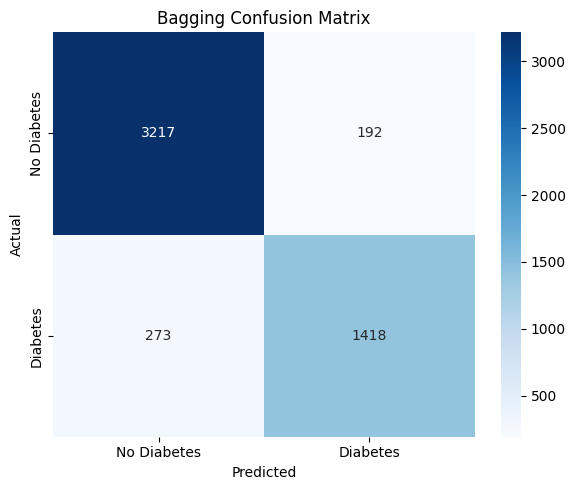

In [ ]:
# Train the bagging model
bagging = BaggingClassifier(n_estimators=100, random_state=42)
bagging.fit(X_train, y_train)

# Evaluate the model
evaluate_model(bagging, X_test, y_test, model_name='Bagging')


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      3409
           1       0.91      0.84      0.87      1691

    accuracy                           0.92      5100
   macro avg       0.92      0.90      0.91      5100
weighted avg       0.92      0.92      0.92      5100



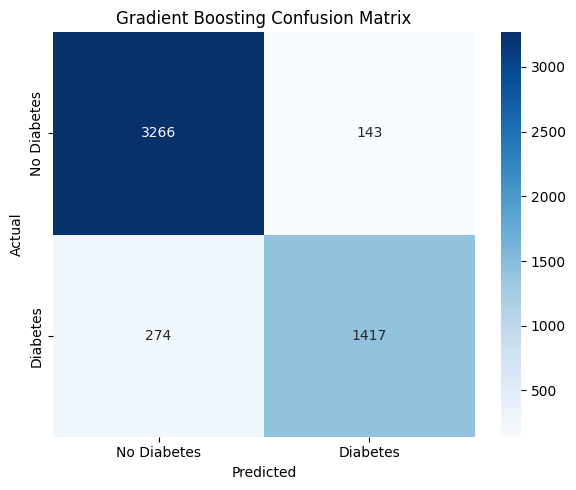

In [ ]:
# Train the gradient boosting model
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)

# Evaluate the model
evaluate_model(gb, X_test, y_test, model_name='Gradient Boosting')


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      3409
           1       0.89      0.84      0.86      1691

    accuracy                           0.91      5100
   macro avg       0.91      0.89      0.90      5100
weighted avg       0.91      0.91      0.91      5100



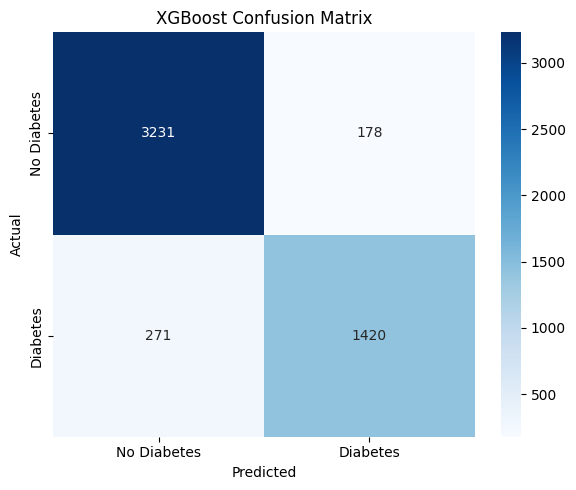

In [ ]:
# Train the XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate the model
evaluate_model(xgb_model, X_test, y_test, model_name='XGBoost')

Performance didn't change much, but our new features are among the most important in these models, so we'll keep them.

## Feature Selection

Now we'll try to do feature selection. Feature selection didn't seem to want to work on bagging, so we'll just try it on gradient boosting and XGBoost.

In [ ]:
from sklearn.feature_selection import SelectFromModel

Selected features for Gradient Boosting:
Index(['age', 'hypertension', 'heart_disease', 'bmi', 'hbA1c_level', 'blood_glucose_level', 'race_Caucasian', 'race_Other', 'gender_Male', 'state_California', 'state_Colorado',
       'state_District of Columbia', 'state_Guam', 'state_Hawaii', 'state_Idaho', 'state_Illinois', 'state_Indiana', 'state_Iowa', 'state_Kansas', 'state_Kentucky', 'state_Maine',
       'state_Massachusetts', 'state_Montana', 'state_Nebraska', 'state_New Hampshire', 'state_New Jersey', 'state_Oklahoma', 'state_Oregon', 'state_Pennsylvania', 'state_Puerto Rico',
       'state_South Carolina', 'state_Texas', 'smoking_past', 'smoking_unknown', 'comorbidity', 'age_bmi_interaction'],
      dtype='object')
36

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      3409
           1       0.91      0.84      0.87      1691

    accuracy                           0.92      5100
   macro avg

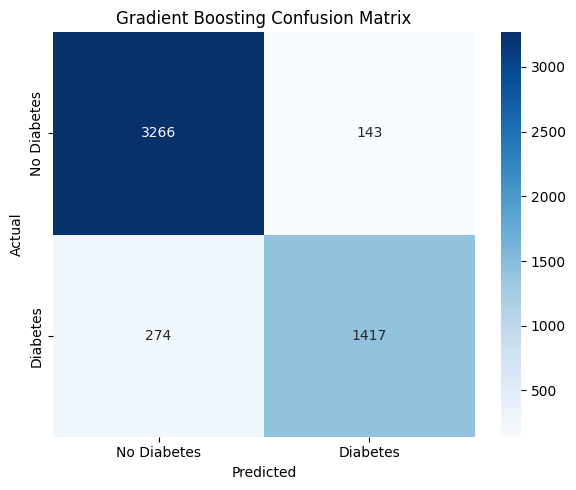

In [ ]:
selector = SelectFromModel(GradientBoostingClassifier(random_state=42), threshold='median')
selector.fit(X_train, y_train)

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

selected_features = X_train.columns[selector.get_support()]
print(f"Selected features for Gradient Boosting:\n{selected_features}")
print(len(selected_features))

# Train the bagging model with the selected features
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train_selected, y_train)

# Evaluate the model
evaluate_model(gb, X_test_selected, y_test, model_name='Gradient Boosting')

Selected features for XGBoost:
Index(['hypertension', 'heart_disease', 'bmi', 'hbA1c_level', 'blood_glucose_level', 'race_Asian', 'race_Hispanic', 'race_Other', 'gender_Male', 'state_Alaska', 'state_Colorado', 'state_Florida',
       'state_Georgia', 'state_Guam', 'state_Idaho', 'state_Illinois', 'state_Indiana', 'state_Iowa', 'state_Louisiana', 'state_Maryland', 'state_Massachusetts', 'state_Michigan', 'state_Minnesota',
       'state_Montana', 'state_New Hampshire', 'state_New York', 'state_North Carolina', 'state_North Dakota', 'state_Ohio', 'state_South Dakota', 'state_United States', 'state_Utah',
       'state_Vermont', 'smoking_unknown', 'comorbidity', 'age_bmi_interaction'],
      dtype='object')

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      3409
           1       0.88      0.84      0.86      1691

    accuracy                           0.91      5100
   macro avg       0.90      0.89   

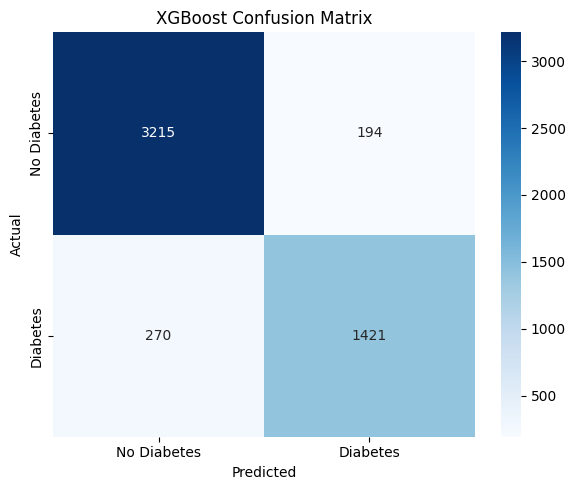

In [ ]:
selector = SelectFromModel(xgb.XGBClassifier(random_state=42), threshold='median')
selector.fit(X_train, y_train)

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

selected_features = X_train.columns[selector.get_support()]
print(f"Selected features for XGBoost:\n{selected_features}")

# Train the XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train_selected, y_train)

# Evaluate the model
evaluate_model(xgb_model, X_test_selected, y_test, model_name='XGBoost')

Feature selection seemed to have essentially no effect, and tree-based models are meant to be robust to large numbers of features, so we'll move on with all features.

## Nested CV

Now we'll finally select our final model using nested CV. We'll evaluate each model based on recall and choose the one that performs best across folds and hyperparameter tuning. We'll use hyperparameter grids with standard ranges of values for the main parameters.

In [ ]:
df_resampled.head()

,age,hypertension,heart_disease,bmi,hbA1c_level,blood_glucose_level,diabetes,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,gender_Other,state_Alaska,state_Arizona,state_Arkansas,state_California,state_Colorado,state_Connecticut,state_Delaware,state_District of Columbia,state_Florida,state_Georgia,state_Guam,state_Hawaii,state_Idaho,state_Illinois,state_Indiana,state_Iowa,state_Kansas,state_Kentucky,state_Louisiana,state_Maine,state_Maryland,state_Massachusetts,state_Michigan,state_Minnesota,state_Mississippi,state_Missouri,state_Montana,state_Nebraska,state_Nevada,state_New Hampshire,state_New Jersey,state_New Mexico,state_New York,state_North Carolina,state_North Dakota,state_Ohio,state_Oklahoma,state_Oregon,state_Pennsylvania,state_Puerto Rico,state_Rhode Island,state_South Carolina,state_South Dakota,state_Tennessee,state_Texas,state_United States,state_Utah,state_Vermont,state_Virgin Islands,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,smoking_never,smoking_past,smoking_unknown,comorbidity,age_bmi_interaction
21695,0.169416,0,0,-0.181738,-0.090983,-1.014449,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,0,-0.011267
62724,0.124456,0,0,-0.889238,0.231417,-1.204346,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,0,-0.385884
38668,0.708938,0,0,0.341925,-0.171583,-1.014449,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,0,0.740736
72816,-1.314270,0,0,-0.918486,0.473217,-1.394242,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,0,-1.338617
14780,0.124456,0,0,-0.606517,-1.541783,-1.394242,0,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,0,-0.250722


In [ ]:
X = df_resampled.drop('diabetes', axis=1)
y = df_resampled['diabetes']

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score
import numpy as np

# Models and corresponding hyperparameter grids
models = {
    'Bagging': (BaggingClassifier(), {
        'n_estimators': [100, 150, 200],
        'max_samples': [0.5, 0.75, 1.0]
    }),
    'Gradient Boosting': (GradientBoostingClassifier(), {
        'n_estimators': [100, 150, 200],
        'learning_rate': [0.01, 0.1, 0.5],
        'max_depth': [3, 5, 7]
    }),
    'XGBoost': (xgb.XGBClassifier(eval_metric='logloss'), {
        'n_estimators': [100, 150, 200],
        'learning_rate': [0.01, 0.1, 0.5],
        'max_depth': [3, 5, 7]
    })
}

# Outer and inner cross-validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def nested_cv(X, y, outer_cv, inner_cv, models):
    results = {}

    for model_name, (model, param_grid) in models.items():
        print(f"Running Nested CV for: {model_name}")

        # GridSearchCV for hyperparameter tuning in the inner loop
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, n_jobs=-1, scoring='recall')

        # Outer CV
        outer_scores = []

        for train_idx, test_idx in outer_cv.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # Fit the inner CV on the training data
            grid_search.fit(X_train, y_train)

            # Get the best model from the inner CV
            best_model = grid_search.best_estimator_

            # Evaluate on the outer test fold
            y_pred = best_model.predict(X_test)
            score = recall_score(y_test, y_pred)
            outer_scores.append(score)

        # Store the results for this model
        results[model_name] = outer_scores

    return results

nested_results = nested_cv(X, y, outer_cv, inner_cv, models)

for model_name, scores in nested_results.items():
    print(f"\n{model_name} Nested CV Recall Scores: {scores}")
    print(f"Mean Recall: {np.mean(scores):.4f}")
    print(f"Standard Deviation of Recall: {np.std(scores):.4f}")


Running Nested CV for: Bagging
Running Nested CV for: Gradient Boosting
Running Nested CV for: XGBoost

Bagging Nested CV Recall Scores: [0.8329411764705882, 0.8229411764705883, 0.821764705882353, 0.8388235294117647, 0.8352941176470589]
Mean Recall: 0.8304
Standard Deviation of Recall: 0.0068

Gradient Boosting Nested CV Recall Scores: [0.8447058823529412, 0.8305882352941176, 0.84, 0.8452941176470589, 0.8482352941176471]
Mean Recall: 0.8418
Standard Deviation of Recall: 0.0062

XGBoost Nested CV Recall Scores: [0.8488235294117648, 0.8288235294117647, 0.8323529411764706, 0.8447058823529412, 0.8482352941176471]
Mean Recall: 0.8406
Standard Deviation of Recall: 0.0084


Gradient boosting and XGBoost were close, but gradient boosting has the slight edge in mean recall and the lowest standard deviation of recall across folds. We think XGBoost might have added a bit too much un-needed complexity. The dataset seemed to be structured and had strong, clean signals (which also contributed to logistic regression's strong performance), so gradient boosting on its own was enough. Also, our dataset is not too large, which perhaps wasn't ideal for XGBoost. Gradient boosting will be our final model.

## Final Model Hyperparameter Tuning

Finally, we'll tune our gradient boosting classifier's hyperparameters and get our final model. Well use a more robust parameter grid, again with standard ranges of values. We'll perform GridSearchCV with StartifiedKFold cross validation.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gb_model = GradientBoostingClassifier(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# Fit on the entire dataset
grid_search.fit(X_train, y_train)

# Best model and hyperparameters
best_gb_model = grid_search.best_estimator_
print(f"\nBest hyperparameters: {grid_search.best_params_}")

results_df = pd.DataFrame(grid_search.cv_results_)
results_df.head()

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [ ]:
print(f"\nBest hyperparameters: {grid_search.best_params_}")


Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


We'll now take a quick look at how some of the hyperparameters affected performance. This graph is a bit all over the place.

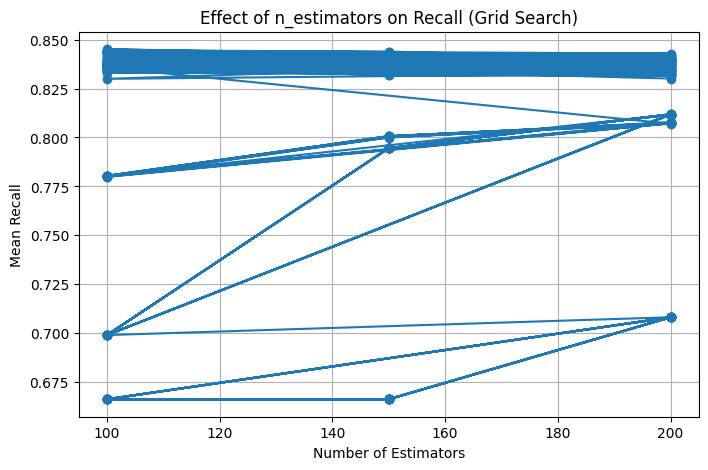

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(results_df['param_n_estimators'], results_df['mean_test_score'], marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Recall')
plt.title('Effect of n_estimators on Recall (Grid Search)')
plt.grid(True)
plt.show()

Here we can see how mean recall reach its peak at a learning rate of 0.1, dipping slghtly as it increased to 0.5.

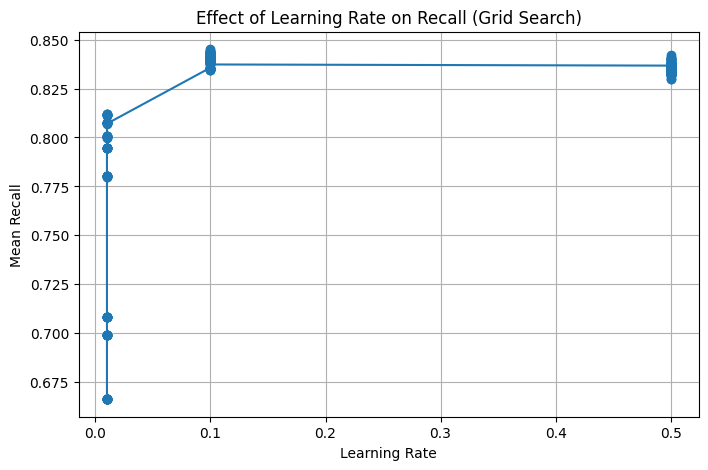

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(results_df['param_learning_rate'], results_df['mean_test_score'], marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Recall')
plt.title('Effect of Learning Rate on Recall (Grid Search)')
plt.grid(True)
plt.show()

Here we can see the heatmap showing recall by the number of estimators and the max depth. With just these two, recall reach its highest point with larger depth and more estimators.

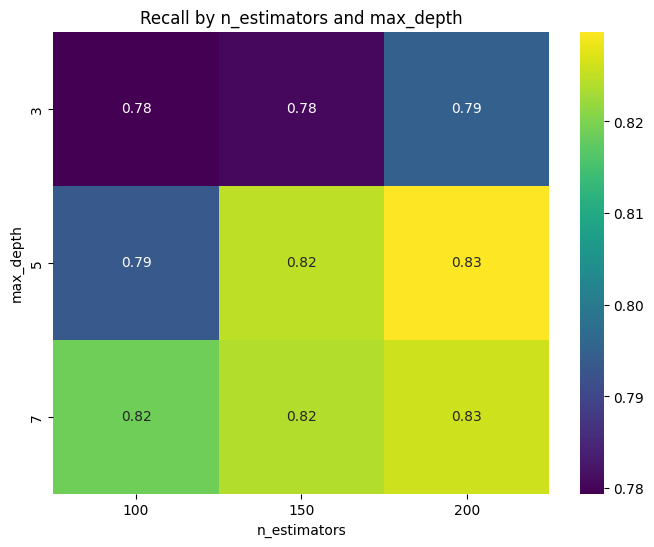

In [ ]:
pivot = results_df.pivot_table(
    index='param_max_depth',
    columns='param_n_estimators',
    values='mean_test_score'
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, cmap='viridis')
plt.title('Recall by n_estimators and max_depth')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.show()

## Final Model Evaluation

Finally, we evaluate our finally model on the test set. We have 84% recall, 89% precision, 87% F1-Score, and 91% accuracy.


Final Gradient Boosting Model Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      3409
           1       0.89      0.84      0.87      1691

    accuracy                           0.91      5100
   macro avg       0.91      0.90      0.90      5100
weighted avg       0.91      0.91      0.91      5100



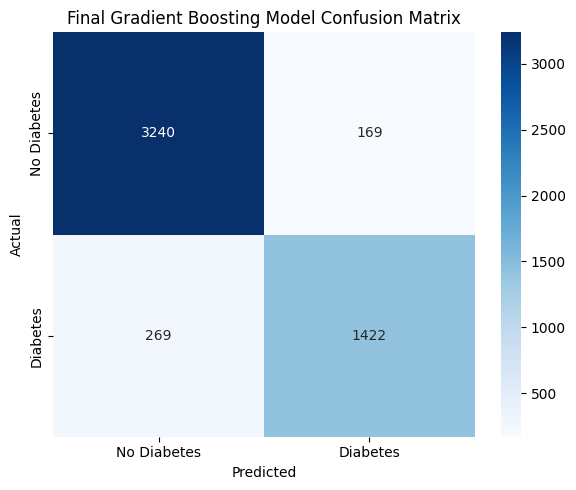

In [ ]:
best_gb_model.fit(X_train, y_train)
y_pred = best_gb_model.predict(X_test)

evaluate_model(best_gb_model, X_test, y_test, model_name='Final Gradient Boosting Model')

Here we have our final model's ROC curve.

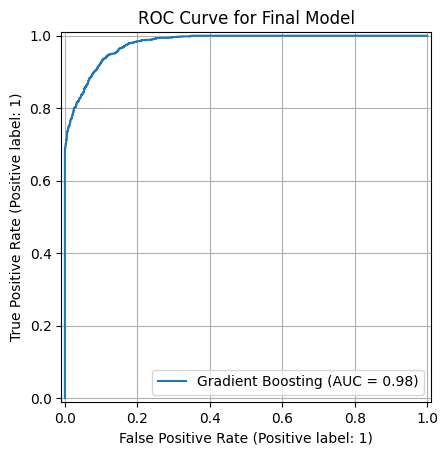

In [ ]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(
    best_gb_model, X_test, y_test,
    name='Gradient Boosting'
)
plt.title('ROC Curve for Final Model')
plt.grid(True)
plt.show()

Here we have our final model precision-recall curve.

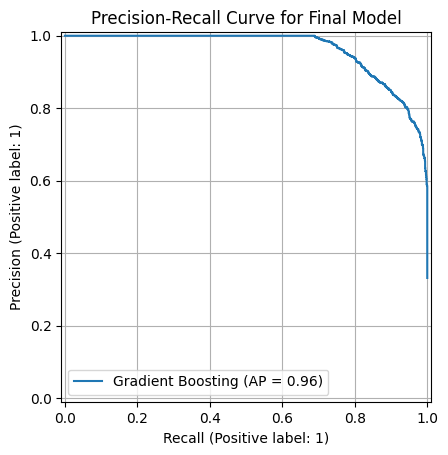

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(
    best_gb_model, X_test, y_test,
    name='Gradient Boosting'
)
plt.title('Precision-Recall Curve for Final Model')
plt.grid(True)
plt.show()

Here we have the feature importances from our final model. As expected, hbA1c and blood glucose level are by far the most important predictors, since they are what gets looked at in actual diabetes diagnosis. Our engineered features, age_bmi_interaction and comorbity, were the next most important features, so it seems those were good additions. It is a bit strange that there are far fewer features with more visible importance here than with the XGBoost model. It seems regular gradient boosting did more extreme "feature selection."

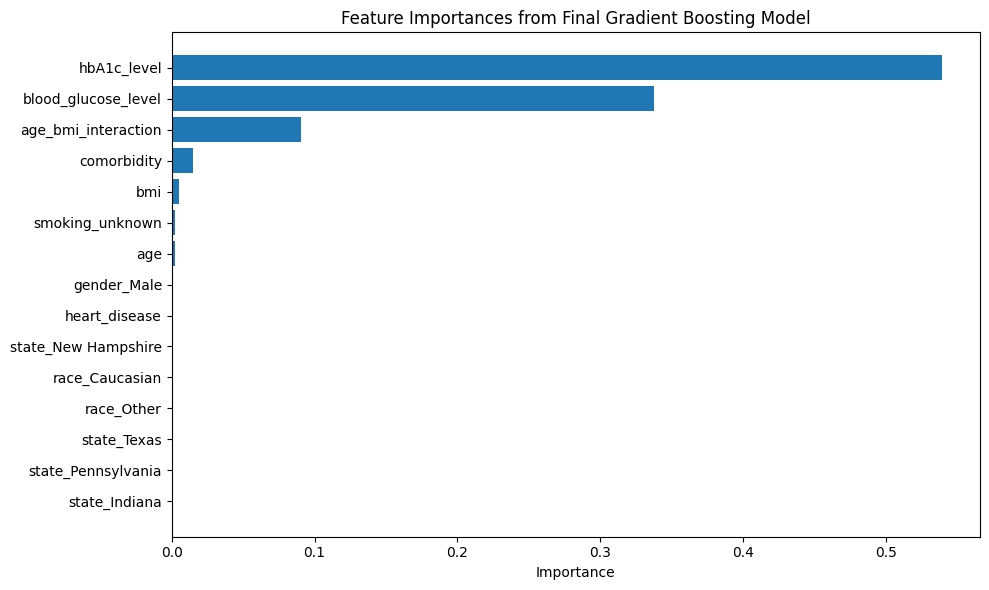

In [ ]:
# Get feature importances
importances = best_gb_model.feature_importances_

# Create DataFrame for sorting
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

top_features = feature_importance_df.head(15)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances from Final Gradient Boosting Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()